In [ ]:
%pip install scikit-learn


<a href="https://colab.research.google.com/github/Urdzik/Colab/blob/main/MDDL_Urdzik_CS26_Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# По прикладу на основі схожого датасету yelp_polarity

In [67]:
!pip install --quiet datasets

In [68]:
!pip install matplotlib

In [69]:
import datasets

In [70]:
yelp_polarity  = datasets.load_dataset("yelp_polarity")

In [71]:
yelp_polarity

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 560000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 38000
    })
})

In [72]:
print(yelp_polarity.keys())

dict_keys(['train', 'test'])


In [118]:
isColab = False # Для зручності робив дз локально і вже фінально ранив на colab зі всіми данними а не з частиною
train_data = yelp_polarity['train']
train_data = train_data.shuffle(seed=42).select(range(6000)) if not isColab else train_data
# test_data = yelp_polarity['test']

In [119]:
train_data

Dataset({
    features: ['text', 'label'],
    num_rows: 10000
})

In [120]:
train_data[100]["text"]

'good food bad service! recommend just doing take out!'

In [121]:
!pip install --quiet spacy

In [122]:
import spacy
import tqdm
from typing import List, Tuple

spacy_nlp = spacy.blank("en")

def tokenize_spacy(text: str) -> List[str]:
  """Tokenize string with SpaCy. """

  tokens = spacy_nlp.tokenizer(text)
  return [str(token) for token in tokens]


def tokenize(text: str) -> List[str]:
  return tokenize_spacy(text)


tokenize_spacy("I can't find my $25! oleksiy@google.com http://google.com/ <b>")

['I',
 'ca',
 "n't",
 'find',
 'my',
 '$',
 '25',
 '!',
 'oleksiy@google.com',
 'http://google.com/',
 '<',
 'b',
 '>']

In [123]:
!pip install pystemmer

In [124]:
import Stemmer
from typing import List

def stem(tokens: List[str]) -> List[str]:
  """Lower-case and stem tokens. """

  stemmer = Stemmer.Stemmer("english")
  tokens = [tok.lower() for tok in tokens]
  return stemmer.stemWords(tokens)

example_tokens = tokenize(train_data[2]["text"])
stemmed_tokens = stem(example_tokens)


In [125]:
for word in ("sing", "sings", "singing", "singer", "singers"):
  stemmed = stem([word])[0]
  print(f"{word:<20}   =>   {stemmed}")

sing                   =>   sing
sings                  =>   sing
singing                =>   sing
singer                 =>   singer
singers                =>   singer


In [126]:
from tqdm import tqdm

all_tokens = []
all_tokens_stemmed = []
for doc in tqdm(train_data):
  doc_tokens = tokenize(doc["text"])
  all_tokens += doc_tokens
  all_tokens_stemmed += stem(doc_tokens)

print("Original unique tokens: {:,}".format(len(set(all_tokens))))
print("Stemmed  unique tokens: {:,}".format(len(set(all_tokens_stemmed))))

100%|██████████| 10000/10000 [00:02<00:00, 3702.76it/s]

Original unique tokens: 52,891
Stemmed  unique tokens: 35,927


In [127]:
# Кастомні стоп-слова, спитав в ChatGPT які краще використати
custom_stop_words = [
    "the", "a", "an", "and", "in", "on", "at", "with", "for", "of", "by", "to",
    "was", "were", "be", "been", "am", "is", "are", "as", "from", "that",
    "this", "it", "you", "your", "we", "they", "he", "she", "my", "i", "me",
    "our", "us", "their", "them", "just", "very", "so", "if", "when", "then"
]
def remove_stop_words(tokens: List[str]) -> List[str]:
  return [token for token in tokens if token not in custom_stop_words]

In [128]:
def preprocess(text: str) -> List[str]:
  tokens = tokenize(text)
  tokens = stem(tokens)
  tokens = remove_stop_words(tokens)
  return tokens

preprocess("I likes it!")

['like', '!']

Top 50 most common tokens account for 47.856300% of tokens
Top 50 tokens are: [('.', 71099), ('the', 65281), (',', 47641), ('and', 42149), ('i', 38421), ('a', 33245), ('to', 33163), ('was', 24682), (' ', 22950), ('it', 21086), ('of', 19891), ('in', 15272), ('for', 15216), ('is', 15018), ('that', 12977), ('!', 11871), ('my', 11572), ('we', 11249), ('you', 10583), ('this', 10543), ('they', 10467), ('but', 10404), ('with', 9892), ("n't", 9304), ('on', 9246), ('not', 9159), ('have', 9018), ('had', 7854), ("'s", 7596), ('at', 7523), ('were', 7512), ('be', 6845), ('so', 6764), ('-', 6619), ('place', 6368), ('are', 6096), ('food', 5896), ('there', 5756), ('"', 5736), ('good', 5331), ('me', 5216), ('like', 5181), ('as', 5122), ('(', 5095), ('get', 4975), (')', 4908), ('do', 4884), ('go', 4849), ('time', 4727), ('out', 4713)]


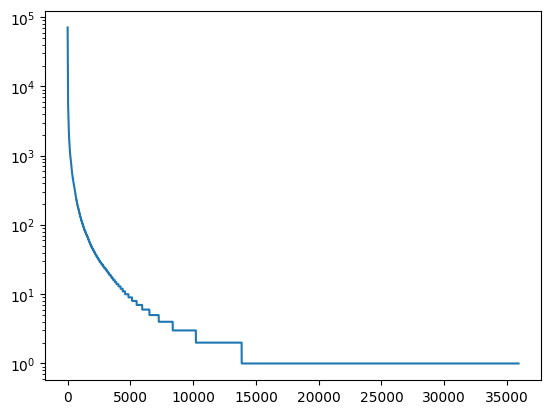

In [129]:
from collections import Counter
import matplotlib.pyplot as plt

# Корпус вже токенізовано в all_tokens та all_tokens_stemmed
assert all_tokens
assert all_tokens_stemmed

# Злічимо усі токени
token_counts = Counter(all_tokens_stemmed)

# Подивимося на 50 найчастотніших токенів
most_common = token_counts.most_common(50)

most_common_count = sum(count for token, count in most_common)
all_count = sum(token_counts.values())
print(f"Top {len(most_common)} most common tokens account for {most_common_count / all_count:%} of tokens")
print(f"Top {len(most_common)} tokens are: {most_common}")

# Розподіл токенів за частотою
plt.yscale("log")
plt.plot(sorted(token_counts.values(), reverse=True))

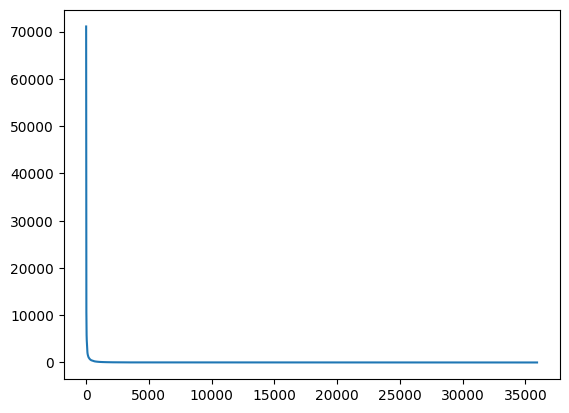

In [130]:
plt.plot(sorted(token_counts.values(), reverse=True))

In [131]:
VOCAB_SIZE = 5000
MIN_COUNT = 5

print(f"Vocab size before filtering: {len(token_counts):,}")

vocab_list = [token for token, count in token_counts.most_common()
              if count > MIN_COUNT
              and token not in custom_stop_words]

print(f"Vocab size after filtering: {len(vocab_list):,}")


vocab_list = vocab_list[:VOCAB_SIZE]
print(f"Final vocab size: {len(vocab_list):,}")

Vocab size before filtering: 35,927
Vocab size after filtering: 6,470
Final vocab size: 5,000


In [132]:
vocab_list[50:60]

['even',
 'more',
 'other',
 'friend',
 'got',
 'look',
 'want',
 'could',
 'come',
 'after']

In [133]:
class Vocabulary:

  def __init__(self, tokens, unk_token="<unk>"):
    self.unk_token = unk_token
    self.unk_index = 0
    self._itos = [unk_token] + tokens
    self._stoi = {token: index for index, token in enumerate(self._itos)}

  def stoi(self, token: str) -> int:
    """Return token index or `<unk>` index if `token` is not in the vocab.
    """
    return self._stoi.get(token, self.unk_index)


  def itos(self, index: int) -> str:
    """Return token by its `index`.

    Raise LookupError if `index` is out of vocabulary range.
    """

    return self._itos[index]

  @property
  def tokens(self):
    return self._itos

  def __len__(self) -> int:
    return len(self._itos)


vocab = Vocabulary(vocab_list)
print(f"Index of `dog` is {vocab.stoi('dog')}")
print(f"Token #42 is `{vocab.itos(42)}`")

Index of `dog` is 410
Token #42 is `realli`


In [134]:
def one_hot(token: str, vocab: Vocabulary) -> List[int]:
    # [0, 0, 0, 1, 0 ,0 ]
    result = [0] * len(vocab)
    index = vocab.stoi(token)
    result[index] = 1
    return result

In [135]:
vector_dog = one_hot("dog", vocab)
len(vector_dog)

5001

In [136]:
vector_dog[:20]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [137]:
vector_dog.index(1)

410

In [138]:
vocab.itos(751)

'face'

In [139]:
def bag_of_words(tokens: List[str], vocab: Vocabulary) -> List[int]:
  result = [0] * len(vocab)

  for token in tokens:
    index = vocab.stoi(token)
    result[index] += 1

  return result

In [140]:
tokens = preprocess("I like like turtles . . . ")
print(f"Tokenized: f{tokens}")
vector_text = bag_of_words(tokens, vocab)
print(vector_text)

Tokenized: f['like', 'like', 'turtl', '.', '.', '.']
[0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [141]:
bag_of_words(preprocess("turtles . . . like I like"), vocab)[:20]

[0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0]

In [142]:
def extract_ngrams(tokens: List[str], max_n: int, min_n: int = 1) -> List[str]:
    """Extract n-grams from `s`.

    Args:
        tokens: list of tokens.
        min_n: Minimum length of n-gram to extract.
        max_n: Maximum length of n-gram to extract.

    Return:
        list of ngrams, where each ngram is as a string.


    Example:
        >>> extract_ngrams("Hello world !", 2)
        ['Hello', 'Hello world', 'world', 'world !', '!']

    """

    return list(extract_ngrams_iter(tokens, max_n, min_n))


def extract_ngrams_iter(tokens: List[str], max_n: int, min_n: int = 1) -> List[str]:
    """Extract all ngrams from `s`, yielding them one by one.

    Example:
        >>> next(extract_ngrams_iter("Hello world !", 2))
        'Hello'

    """

    for i in range(len(tokens)):
        for j in range(min_n, max_n + 1):
            if i + j <= len(tokens):
                ngram = tokens[i : i + j]
                ngram = " ".join(ngram)
                yield ngram


extract_ngrams("hello world !".split(), 2)

['hello', 'hello world', 'world', 'world !', '!']

In [143]:
counts = Counter()
for doc in tqdm(train_data):
  tokens = preprocess(doc["text"])
  ngrams = extract_ngrams(tokens, 2)
  counts.update(ngrams)

ngrams_vocab = [token for token, count in counts.most_common() if count > MIN_COUNT]
ngrams_vocab = ngrams_vocab[:VOCAB_SIZE]
ngrams_vocab = Vocabulary(ngrams_vocab)

100%|██████████| 10000/10000 [00:02<00:00, 3512.95it/s]


In [144]:
len(ngrams_vocab)

5001

In [145]:
[x for x in ngrams_vocab._itos ][1000:1020]

['100',
 '. said',
 'do .',
 'bought',
 'unless',
 'grab',
 '... but',
 'bother',
 'longer',
 'de',
 'station',
 '  veri',
 'minut .',
 '5 star',
 'bad .',
 'have no',
 'non',
 'had no',
 'answer',
 'help .']

In [147]:
def bag_of_ngrams(tokens: List[str], vocab: Vocabulary) -> List[int]:
  result = [0] * len(vocab)
  ngrams = extract_ngrams(tokens, 2)
  for ngram in ngrams:
    index = vocab.stoi(ngram)
    result[index] += 1

  return result

In [148]:
print(bag_of_ngrams(preprocess("I couldn't resist"), ngrams_vocab))

[2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [149]:
from hashlib import md5

def bag_of_hashed_ngrams(ngrams: List[str], vocab_size) -> List[int]:
    result = [0] * vocab_size
    for ngram in ngrams:
        index = md5(ngram).digest % vocab_size
        result[index] += 1
    return result

In [150]:
import numpy as np


def vectorize(data: 'datasets.Dataset') -> Tuple[np.array, np.array]:
  X_list = []
  y_list = []
  for doc in data:
    tokens = preprocess(doc["text"])
    X_list.append(bag_of_ngrams(tokens, ngrams_vocab))
    y_list.append(doc["label"])  # 0 or 1
  X = np.array(X_list)
  y = np.array(y_list)
  return (X, y)

# Take random 2000 documents for a dev set
valid_data = yelp_polarity["test"].shuffle(seed=1).filter(lambda x, i: i < 2000, with_indices=True)

X_train, y_train = vectorize(train_data)
X_val, y_val = vectorize(valid_data)


Filter: 100%|██████████| 38000/38000 [00:00<00:00, 190705.84 examples/s]


In [151]:
X_train.shape
X_val

array([[ 21,   3,   0, ...,   0,   0,   0],
       [ 77,   8,   4, ...,   0,   0,   0],
       [146,   9,   2, ...,   0,   0,   0],
       ...,
       [ 18,   3,   0, ...,   0,   0,   0],
       [638,  29,  57, ...,   0,   0,   0],
       [ 88,   6,   0, ...,   0,   0,   0]], shape=(2000, 5001))

In [153]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear', C=0.5, penalty="l1")
model.fit(X_train, y_train)

,penalty,'l1'
,dual,False
,tol,0.0001
,C,0.5
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


In [154]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

def evaluate(model):
  y_hat = model.predict(X_val)
  accuracy = (y_hat == y_val).mean()

  return {
      "accuracy": accuracy,
      "precision": precision_score(y_val, y_hat),
      "recall": recall_score(y_val, y_hat),
      "f1": f1_score(y_val, y_hat),
  }

metrics = evaluate(model)
print(f"Log regression: {metrics}")

Log regression: {'accuracy': np.float64(0.9195), 'precision': 0.9138099902056807, 'recall': 0.9274353876739563, 'f1': 0.9205722742969906}


/Users/urdzik/Developer/HomeWork2/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/urdzik/Developer/HomeWork2/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/urdzik/Developer/HomeWork2/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


/Users/urdzik/Developer/HomeWork2/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/urdzik/Developer/HomeWork2/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/urdzik/Developer/HomeWork2/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


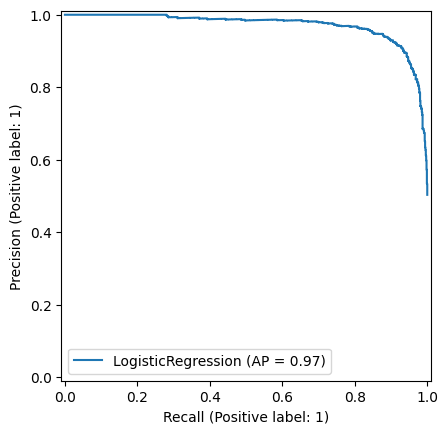

In [155]:
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_estimator(model, X_val, y_val)

In [156]:
def predict(text: str, model: 'BaseEstimator') -> float:
  tokens = preprocess(text)
  features = bag_of_ngrams(tokens, ngrams_vocab)
  features = np.array([features])
  prob_neg, prog_pos = model.predict_proba(features)[0]
  return prog_pos

In [201]:
threshold = 0.5
predict("I like", model) > threshold

/Users/urdzik/Developer/HomeWork2/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/urdzik/Developer/HomeWork2/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/urdzik/Developer/HomeWork2/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


np.True_

In [ ]:
import datasets
dataset = datasets.load_dataset('yelp_polarity')
train_data = dataset['train']
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(
    max_features=1000,
    ngram_range=(1,3),
    binary=True,
    stop_words=custom_stop_words,
    # vocabulary=vocab.tokens,
    )
X_train = vectorizer.fit_transform(train_data[:]["text"])

In [ ]:
X_train

In [ ]:
vectorizer.get_feature_names_out()[1000:1010]

In [ ]:
from sklearn.linear_model import LogisticRegression
model2 = LogisticRegression(solver='liblinear', C=0.1, penalty="l1")
model2.fit(X_train, train_data["label"])

In [ ]:
from sklearn.metrics import accuracy_score

valid_data = yelp_polarity["test"].shuffle(seed=1).filter(lambda x, i: i < 2000, with_indices=True)
X_valid = vectorizer.fit_transform(valid_data["text"])
y_valid = valid_data["label"]

y_pred = model2.predict(X_valid)
accuracy_score(y_valid, y_pred)

In [ ]:
threshold = 0.5
predict("I like", model2) > threshold